# Baum-Welch algorithm  

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Forward-Algorithm" data-toc-modified-id="Forward-Algorithm-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Forward Algorithm</a></span></li><li><span><a href="#Backward-Algorithm" data-toc-modified-id="Backward-Algorithm-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Backward Algorithm</a></span></li><li><span><a href="#Baum-Welch" data-toc-modified-id="Baum-Welch-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Baum Welch</a></span></li><li><span><a href="#Test-Case" data-toc-modified-id="Test-Case-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Test Case</a></span></li></ul></div>

## Introduction

We model CpG islands by creating a Hidden Markov Model of the 1st order. The model assumes the presence of two “hidden” states: CpG island and nonCpG island.  

* Estimate transition and emission probabilities of the model only based on sequences containing CpG islands without known keys. 

* For this we apply Baum-Welch algorithm. We use the first 100 sequences from the file “Sequences.txt” and the given starting parameter values to train the model.

To avoid underflows, all calculations are performed in the logarithmic space: 

$log(𝑝+𝑞)=log(e^{log(p)}+𝑒^{log(q)})$. 

We stop the algorithm, when the absolute change in the sum of probabilities of training sequences between two iterations becomes less than 0.001 (in the log space). 

## Imports

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import math

In [127]:
# Transition matrix:
transmat = [[0.7, 0.3], [0.3, 0.7]]

# Emission matrix
emmat = [[0.1, 0.1, 0.4, 0.4], [0.25, 0.25, 0.25, 0.25]]

# Initiation matrix
initmat = [0.5, 0.5]

# Reading Sequences from Sequences.txt
f = open("Sequences.txt", "r")
sequences = []
for line in f:
    sequences.append(line[:-1])
sequences = sequences[:100]

## Forward Algorithm

In [113]:
def forward(sequence, initmat, a, e):
    states = [0, 1]
    seqlen = len(sequence)
    f = [[0]*seqlen, [0]*seqlen]
    ptr = [[0]*seqlen]
    nucleotide = {"A": 0, "T": 1, "G": 2, "C": 3}
    for k in states:
        f[k][0] = initmat[k]*e[k][nucleotide[sequence[0]]]
    for i in range(1, seqlen):
        for k in states:
            # Sum of both last previous probs*transitions for each state
            f[k][i] = f[states[0]][i-1]*a[states[0]][k]
            # Remaining state
            for l in states[1:]:
                f[k][i] += f[l][i-1]*a[l][k]
            f[k][i] = f[k][i]*e[k][nucleotide[sequence[i]]]
    return f

## Backward Algorithm

In [115]:
def backward(sequence, initmat, a, e):

    states = [0, 1]
    seqlen = len(sequence)
    b = [[0]*seqlen, [0]*seqlen]
    nucleotide = {"A": 0, "T": 1, "C": 2, "G": 3}

    for k in states:
        b[k][-1] = 1

    for i in np.arange(seqlen-2, -1, -1):
        # -1 for index shift, -1 for second last column

        for k in states:
            b[k][i] = b[states[0]][i+1] * a[k][states[0]] * \
                e[states[0]][nucleotide[sequence[i+1]]]

            # Remaining state
            for l in states[1:]:
                b[k][i] += b[l][i+1]*a[k][l]*e[l][nucleotide[sequence[i+1]]]
            b[k][i] = b[k][i]

    start = 0
    for k in states:
        start += b[k][0]*e[k][nucleotide[sequence[0]]]*initmat[k]

    return b

## Baum Welch

In [117]:
def BaumWelch(sequences, initmat, a, e, eps):
    states = [0, 1]
    nucleotide = {"A": 0, "T": 1, "C": 2, "G": 3}
    converged = 1

    while (converged > eps):
        delta = 0
        current = 0
        A = np.zeros((2, 2))
        E = np.zeros((2, 4))

        for ind, j in enumerate(sequences):
            f = forward(j, initmat, a, e)
            b = backward(j, initmat, a, e)
            V = np.sum(f, axis=0)[-1]
            current += np.log(V)

            for i in range(len(j)-1):
                for s in states:
                    E[s][nucleotide[j[i]]] += f[s][i]*b[s][i]/V
                    for s2 in states:
                        A[s, s2] += f[s][i]*a[s][s2] * \
                            e[s2][nucleotide[j[i+1]]]*b[s2][i+1]/V

        for i in range(2):
            # Scaling
            a[i] = np.divide(A[i], np.sum(A[i]))
            e[i] = np.divide(E[i], np.sum(E[i]))

        for i in range(100):
            f = forward(sequences[i], initmat, a, e)
            V = np.sum(f, axis=0)[-1]
            delta += np.log(V)

        converged = abs(current-delta)

    return a, e

## Test Case

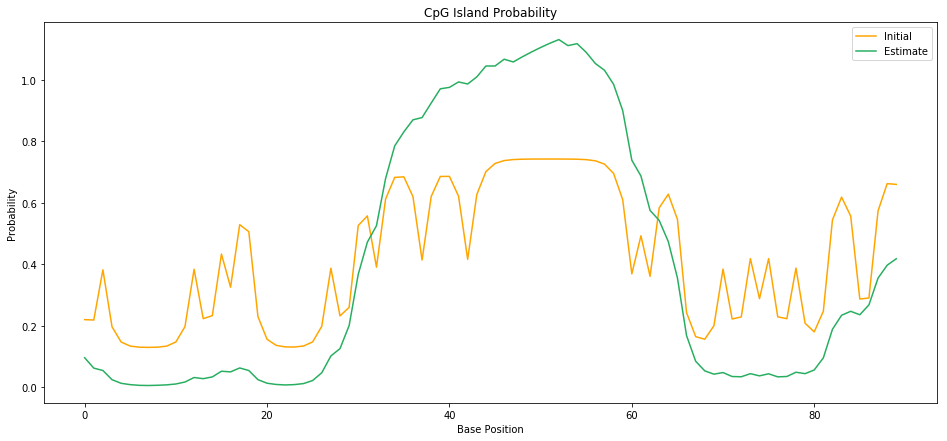

In [133]:
# Recover all matrices
transmat = [[0.7, 0.3], [0.3, 0.7]]
emmat = [[0.1, 0.1, 0.4, 0.4], [0.25, 0.25, 0.25, 0.25]]
initmat = [0.5, 0.5]

test_sequence = "AACAATAATTTTGTTCTCCAATATAATCATCGACGCGTCGCGACGCGCGGGGGCGCCGGGTGACCCTATACTTCACTTGAATGCCATCCG"

f1 = forward(test_sequence, initmat, transmat, emmat)
b1 = backward(test_sequence, initmat, transmat, emmat)
probs1 = np.multiply(f1, b1) / np.sum(f1, axis=0)[-1]


a_estimate, e_estimate = BaumWelch(sequences, initmat, transmat, emmat, 0.001)
f2 = forward(test_sequence, initmat, a_estimate, e_estimate)
b2 = backward(test_sequence, initmat, a_estimate, e_estimate)
probs2 = np.multiply(f2, b2) / np.sum(f2, axis=0)[-1]

plt.figure(figsize=(16, 7))
plt.title("CpG Island Probability")
plt.plot(probs1[0], label="Initial", color='orange')
plt.plot(probs2[0], label="Estimate", color='#27ae60')
plt.xlabel('Base Position')
plt.ylabel('Probability')
plt.legend(loc='best')
plt.show()